In [48]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B,TNC
from qiskit_algorithms.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit
import numpy as np
import matplotlib.pyplot as plt
import time, copy, warnings

import torch
import torchvision

from torchvision import datasets, transforms

from sklearn import linear_model, svm
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from qiskit_algorithms.utils import algorithm_globals

np.random.seed(42)
algorithm_globals.random_seed = 12345


### Load the dataset

In [49]:
# Load MNIST dataset
def load_dataset(size,train=True):
    root = '~/Documents/image_datasets/MNIST'
    dataset = datasets.MNIST(root=root, train=train, download=True,
                             transform=transforms.Compose([
                                 transforms.Resize((size, size)),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=(0.5,), std=(0.5,))
                             ]))
    return dataset


size = 4
trainset = load_dataset(train=True,size=size)
testset = load_dataset(train=False,size=size)



### Take subset of data with few classes

In [50]:
# Generate subset from dataset
def generate_subset(dataset, *classes):
    class_indices = torch.cat([torch.where(dataset.targets == c)[0] for c in classes])
    subset = torch.utils.data.Subset(dataset, class_indices)
    X = np.array([image.flatten().numpy() for image, _ in subset])
    y = np.array([label for _, label in subset])
    return X, y




# 
classes = [0, 1]
X_train, y_train = generate_subset(trainset, *classes)
X_test, y_test = generate_subset(testset, *classes)



### Select subset of the subset randomly(Optional)

In [51]:
# # Randomly sample a subset of data (optional)
# random_indices_test = np.random.choice(range(len(X_test)), 100, replace=False)
# X_test, y_test = X_test[random_indices_test], y_test[random_indices_test]

# random_indices_train = np.random.choice(range(len(X_train)), 1000, replace=False)
# X_train, y_train = X_train[random_indices_train], y_train[random_indices_train]

### Information about the data

In [52]:
import pandas as pd
# size of the test and train set
# print(f'Size of Training set is   \n and Testing set is ')
print(f'**Number of features in data is {X_train.shape[1]}')
print(f'**Number of Classes are {len(classes)} which are {classes}')
print(f'**Total Training samples = {X_train.shape[0]} \n**Datapoints  in each class in Training data are \n {pd.DataFrame(y_train).value_counts()}')
print(f'**Total Testing samples = {X_test.shape[0]} \n**Datapoints  in each class in Testing data are \n {pd.DataFrame(y_test).value_counts()}')


**Number of features in data is 16
**Number of Classes are 2 which are [0, 1]
**Total Training samples = 12665 
**Datapoints  in each class in Training data are 
 0
1    6742
0    5923
Name: count, dtype: int64
**Total Testing samples = 2115 
**Datapoints  in each class in Testing data are 
 0
1    1135
0     980
Name: count, dtype: int64


### Encoding of data

In [53]:
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit_machine_learning.circuit.library import RawFeatureVector
import numpy as np

def create_feature_map(size, encoding):
    """
    Creates a feature map circuit based on the specified encoding type.

    Parameters:
        size (int): The size of the features.
        encoding (str): The encoding type. Choose from 'Pauli', 'Z', 'ZZ', or 'RawFeatureVector'.

    Returns:
        qiskit.QuantumCircuit: The feature map quantum circuit.
    """

    num_features = size ** 2
    num_qubits = num_features

    if encoding == 'Pauli':
        fm = PauliFeatureMap(feature_dimension=num_features, reps=1, paulis=['Z'])
    elif encoding == 'Z':
        fm = ZFeatureMap(feature_dimension=num_features, reps=1)
    elif encoding == 'ZZ':
        fm = ZZFeatureMap(feature_dimension=num_features, reps=1)
    elif encoding == 'RawFeatureVector':
        num_qubits = int(np.log2(num_features))
        fm = RawFeatureVector(feature_dimension=num_features)
    else:
        raise ValueError("Invalid encoding type. Choose from 'Pauli', 'Z', 'ZZ', or 'RawFeatureVector'.")

    # print(f'number of (features, qubits) = {num_features, num_qubits}')

    return fm, num_qubits

# Example usage:
encoding = 'RawFeatureVector'
fm,num_qubits = create_feature_map(size, encoding)
fm.draw()
# def featureMap(n_qubits,data):
#     qc = QuantumCircuit(n_qubits,2)
#     for i, x in enumerate(data):
#         qc.rx(x,i)
#     return qc
# qc = featureMap(16,X_train[0])

# qc.measure_all()
# qc.draw('mpl')

»
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
«     ┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
«q_0: ┤0                                                                                                                ├
«     │                                                                                                                 │
«q_1: ┤1                                                                                                                ├
«     │  Parameterizedinitialize(x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15]) │
«q_2: ┤2                                                                                                                ├
«     │                                                                                                                 │
«q_3: ┤3                                                                                                                ├
«     └─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

### Customized PQC

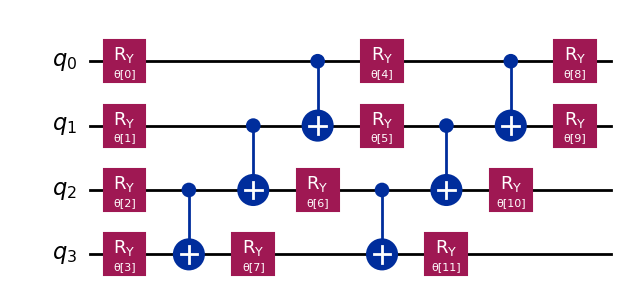

In [54]:
from qiskit.circuit.library import RealAmplitudes


pqc = RealAmplitudes(num_qubits=num_qubits, reps=2)
pqc.decompose().draw('mpl')
# N=16
# def variational_circuit(qc,theta):
#     for i in range(N-1):
#         qc.cx(i,i+1)
#     for i in range(N):
#         qc.ry(theta[i],i)
#     return qc
# qc = variational_circuit(qc,np.random.rand(N))
# qc.draw('mpl')

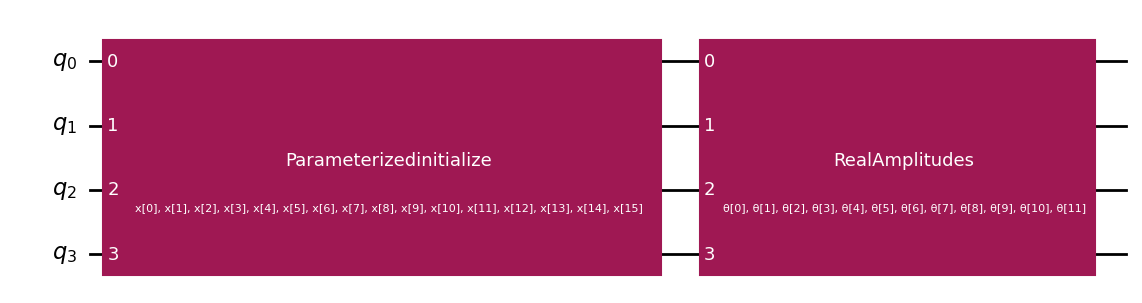

In [56]:
## Combined circuit
vqc_ckt = fm.compose(pqc)
# vqc_ckt=vqc_ckt.compose(fm)
vqc_ckt.draw('mpl')

In [55]:
from qiskit.primitives import Estimator, Sampler
#estimator = Estimator()
sampler=Sampler()
x0 = np.random.rand(pqc.num_parameters)
x0

array([0.37454012, 0.95071431, 0.73199394, 0.59865848, 0.15601864,
       0.15599452, 0.05808361, 0.86617615, 0.60111501, 0.70807258,
       0.02058449, 0.96990985])

In [41]:
# # Example usage:
input_size = 2**num_qubits  # Size of the input vector
output_size = len(classes)    # Size of the output vector

# Initialize the model
model = FCL(input_size, output_size)
vqc_ckt = fm.compose(pqc)
parameters = list(X_train[0]) + list(x0)
vqc_ckt.measure_all()
job = sampler.run(vqc_ckt, parameters)
res = job.result().quasi_dists
# res
dis=list(res[0].values())
#apply lambda function
true = [0]*len(dis)
if y_train[0]==0:
    for j in range(len(true)):
            if j%2==0:
                true[j] = 1/8
else:
    for j in range(len(true)):
        if j%2!=0:
            true[j] = 1/8
print(dis)
print(true)


[0.0159326845967117, 0.0006437132065103, 0.0009735835018421, 0.0519922337378592, 0.0198399318093414, 8.88757574788e-05, 0.0198588159975406, 0.0970832172102527, 0.0007206779201283, 0.0199880826415627, 0.0019541763615628, 0.4097212005444522, 0.0077062868588867, 0.0131242494219632, 0.0929050987565341, 0.2474671716773728]
1.0


In [45]:
import numpy as np
pred = np.array(dis)
true_label =np.array(true)

loss = (pred-true)

print(loss)

[-1.09067315e-01  6.43713207e-04 -1.24026416e-01  5.19922337e-02
 -1.05160068e-01  8.88757575e-05 -1.05141184e-01  9.70832172e-02
 -1.24279322e-01  1.99880826e-02 -1.23045824e-01  4.09721201e-01
 -1.17293713e-01  1.31242494e-02 -3.20949012e-02  2.47467172e-01]


In [46]:
def cross_entropy(y_pred, y_true):
    # Convert y_pred and y_true to PyTorch tensors
    y_pred_tensor = torch.tensor(y_pred, dtype=torch.float32)
    y_true_tensor = torch.tensor(y_true, dtype=torch.float32)

    # Ensure y_pred_tensor has the shape of y_true_tensor
    if y_pred_tensor.shape != y_true_tensor.shape:
        raise ValueError("Shapes of y_pred and y_true must match.")
    # Compute softmax values for predicted probabilities
    # y_pred_softmax = torch.softmax(y_pred_tensor, dim=-1)
    y_true_softmax = torch.softmax(y_true_tensor, dim=-1)

    # Compute cross-entropy loss
    loss = -torch.sum(y_true_softmax * torch.log(y_pred_tensor + 1e-10))
    # print(loss)
    return loss.item()
cross_entropy(pred,true_label)

4.535815238952637

In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class QuantumClassicalHybrid(nn.Module):
    def __init__(self, qvc, qvc_output_size, num_classes):
        super(QuantumClassicalHybrid, self).__init__()
        
        # Define Quantum Variational Circuit (QVC)
        self.qvc = qvc
        
        # Define Classical Neural Network Layers
        self.fc1 = nn.Linear(qvc_output_size, 128)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        # Pass input through Quantum Variational Circuit (QVC)
        qvc_output = self.qvc(x)
        
        # Pass QVC output through Classical Neural Network Layers
        x = F.relu(self.fc1(qvc_output))
        x = self.fc2(x)
        
        return x

# Example usage:
input_size = 2**num_qubits  # Size of the input vector
output_size = len(classes)    # Size of the output vector

# Initialize the quantum variational circuit
# Note: You need to initialize fm and pqc before passing them to the model
# fm, num_qubits = create_feature_map(size, encoding)
# pqc = RealAmplitudes(num_qubits=num_qubits, reps=2)
# sampler = Sampler()

# Initialize the hybrid model
model = QuantumClassicalHybrid(fm.compose(pqc), input_size, output_size)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert data to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


TypeError: 'RawFeatureVector' object is not callable